In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, matplotlib.patches as mpatches
from datetime import date, datetime, timedelta
from scipy.stats import ks_2samp, mannwhitneyu, shapiro, ttest_ind
sns.set_theme(style="ticks")
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# parameter

In [2]:
yeari, yearf = '2024', '2024'
weeki, weekf = '18', '31'

In [3]:
di = datetime.strptime(f'{yeari}-{weeki}-1', "%Y-%W-%w").date()
df = datetime.strptime(f'{yearf}-{weekf}-1', "%Y-%W-%w").date() + timedelta(6)
ds = [di+timedelta(dt) for dt in range((df-di).days+1)]
daylist = ds
print(di, 'until', df)

2024-04-29 until 2024-08-04


In [4]:
cdef = 'tl7_10m'# 'tl5_10m' 'tl6_10m' 'tl7_10m' 'tl8_10m' 'tl8_60m'
cdef_alt = '16m_10min'# tl5: 62 ... tl7: 16   tl8: 8

# load data

In [5]:
# load event data
combined_df = pd.read_csv('data/metadata/event_data.csv')
combined_df = combined_df[['city','day','match']]
combined_df['day'] = [d.date() for d in pd.to_datetime(combined_df.day)]

# analyses

In [6]:
#event_here, event_hour = 'Rammstein', 19
#event_here, event_hour = 'AC/DC', 20
#event_here, event_hour = 'T Swift', 18
event_here, event_hour = 'DoKomi', 10
#event_here, event_hour = 'Japan Day', 11

In [7]:
combined_df_lmtd = combined_df[(combined_df.match==event_here)].copy(deep=True)
combined_df_lmtd['hour_match'] = event_hour
combined_df_base = combined_df_lmtd.copy(deep=True)
combined_df_base['day'] = combined_df_base.day - timedelta(7)
combined_df_base['match'] = 'base'
combined_df_lmtd = pd.concat([combined_df_lmtd, combined_df_base])
combined_df_lmtd

,city,day,match,hour_match
71,Düsseldorf,2024-06-28,DoKomi,10
72,Düsseldorf,2024-06-29,DoKomi,10
73,Düsseldorf,2024-06-30,DoKomi,10
71,Düsseldorf,2024-06-21,base,10
72,Düsseldorf,2024-06-22,base,10
73,Düsseldorf,2024-06-23,base,10


In [8]:
# execute if using non-event baseline (instead of non-Germany match baseline)
dbase = pd.DataFrame(pd.date_range(date(2024,6,10), date(2024,8,4)), columns=['day'])
dbase['day'] = dbase.day.apply(lambda x: x.date())
dbase = dbase.merge(pd.DataFrame(list(set(combined_df.city)), columns=['city']), how='cross')
dbase = dbase.merge(combined_df, on=['day','city'], how='left')
dbase = dbase[dbase.match.isna()].drop(columns='match')
dbase['wd'] = dbase.day.apply(lambda x: x.weekday())
dbase

combined_df_lmtd = combined_df[combined_df.match==event_here].copy(deep=True)
combined_df_lmtd['hour_match'] = event_hour
combined_df_base = combined_df_lmtd.copy(deep=True)
combined_df_base['wd'] = combined_df_base.day.apply(lambda x: x.weekday())
combined_df_base = combined_df_base.drop(columns=['day','match']).merge(dbase, on=['city','wd'])
combined_df_base['match'] = 'base'
combined_df_base = combined_df_base.drop(columns=['wd'])
combined_df_lmtd = pd.concat([combined_df_lmtd, combined_df_base])
combined_df_lmtd

,city,day,match,hour_match
71,Düsseldorf,2024-06-28,DoKomi,10
72,Düsseldorf,2024-06-29,DoKomi,10
73,Düsseldorf,2024-06-30,DoKomi,10
0,Düsseldorf,2024-06-14,base,10
1,Düsseldorf,2024-07-05,base,10
2,Düsseldorf,2024-07-12,base,10
3,Düsseldorf,2024-07-26,base,10
4,Düsseldorf,2024-08-02,base,10
5,Düsseldorf,2024-06-15,base,10
6,Düsseldorf,2024-06-22,base,10


In [9]:
data = pd.read_csv('data/fig4/contacts_cities_stadiums.csv')
data['day'] = [d.date() for d in pd.to_datetime(data.day)]
data['stime'] = pd.to_datetime(data.stime)# - timedelta(minutes=30)
data['hour'] = data.stime.dt.hour
#data['hour'] = 2*data.stime.dt.hour + data.stime.apply(lambda x: 0 if x.minute<30 else 1)

In [10]:
for_heatmap = data.groupby(['city','day','hour']).pair.apply(lambda x: len(set(x))).reset_index()
c1 = pd.DataFrame(set(for_heatmap.city), columns=['city'])
c3 = pd.DataFrame([d.date() for d in pd.date_range(di, df)], columns=['day'])
c4 = pd.DataFrame(list(range(24)), columns=['hour'])
for_heatmap = c1.merge(c3, how='cross').merge(c4, how='cross').merge(for_heatmap, on=['city','day','hour'], how='left')
for_heatmap

,city,day,hour,pair
0,München,2024-04-29,0,NaN
1,München,2024-04-29,1,NaN
2,München,2024-04-29,2,NaN
3,München,2024-04-29,3,NaN
4,München,2024-04-29,4,NaN
...,...,...,...,...
23515,Berlin,2024-08-04,19,126.0
23516,Berlin,2024-08-04,20,127.0
23517,Berlin,2024-08-04,21,126.0
23518,Berlin,2024-08-04,22,38.0


In [11]:
# count the contacts by city, day and hour and join them on the match metadata by city and day
combined_df_lmtd = combined_df_lmtd.merge(for_heatmap.groupby(['city','day','hour']).pair.sum().reset_index(), on=['city','day'])
# define a time relative to start of the match
combined_df_lmtd['hour_rel'] = combined_df_lmtd.hour - combined_df_lmtd.hour_match
# define a flag on whether the match involved Germany
combined_df_lmtd['germany'] = combined_df_lmtd.match.apply(lambda x: x==event_here)
combined_df_lmtd

,city,day,match,hour_match,hour,pair,hour_rel,germany
0,Düsseldorf,2024-06-28,DoKomi,10,0,1.0,-10,True
1,Düsseldorf,2024-06-28,DoKomi,10,1,0.0,-9,True
2,Düsseldorf,2024-06-28,DoKomi,10,2,0.0,-8,True
3,Düsseldorf,2024-06-28,DoKomi,10,3,0.0,-7,True
4,Düsseldorf,2024-06-28,DoKomi,10,4,0.0,-6,True
...,...,...,...,...,...,...,...,...
451,Düsseldorf,2024-08-04,base,10,19,9.0,9,False
452,Düsseldorf,2024-08-04,base,10,20,7.0,10,False
453,Düsseldorf,2024-08-04,base,10,21,9.0,11,False
454,Düsseldorf,2024-08-04,base,10,22,3.0,12,False


In [12]:
# compute baseline as total contact number in a given city on a given day
sumtoone = False
if sumtoone:
    baseline = combined_df_lmtd.groupby(['city','day']).pair.apply(np.sum).reset_index().rename(columns={'pair':'baseline'})
else:
    hour_min = [14-event_hour]
    baseline = combined_df_lmtd[(combined_df_lmtd.hour_rel.isin(hour_min)) & (combined_df_lmtd.match=='base')].groupby(['city']).pair.apply(np.median).reset_index().rename(columns={'pair':'baseline'})
baseline

,city,baseline
0,Düsseldorf,19.5


In [13]:
# compute hourly share of contacts over the day
if sumtoone:
    combined_df_tobase = combined_df_lmtd.merge(baseline, on=['city','day'])
else:
    combined_df_tobase = combined_df_lmtd.merge(baseline, on=['city'])
combined_df_tobase['normed'] = combined_df_tobase.pair / combined_df_tobase.baseline

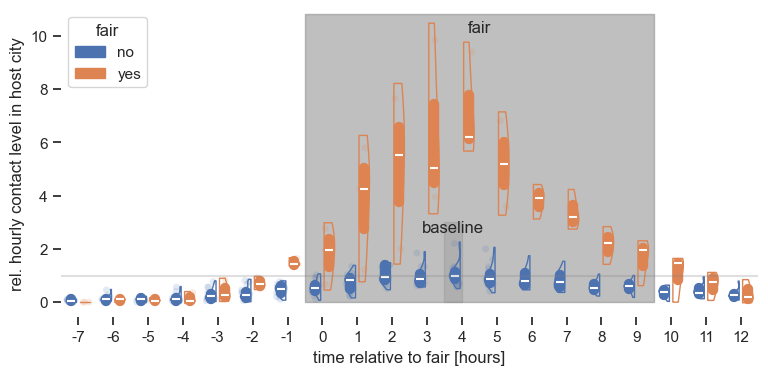

In [14]:
if event_here in ['DoKomi', 'Japan Day']:
    hour_min_show, hour_max_show = -7, 12
else:
    hour_min_show, hour_max_show = -7, 5
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(9, 4))
#ax.set_xscale("log")

yup = 1.1*combined_df_tobase.normed.max()
if event_here in ['DoKomi', 'Japan Day']:
    ax.fill_between([-hour_min_show-.5,-hour_min_show-.5+10], [yup,yup], color='gray', zorder=0, alpha=.5)
    ax.text(-hour_min_show-.5+5, .95*yup, 'fair', ha='center', va='center')
else:
    ax.fill_between([-hour_min_show-.5,-hour_min_show-.5+4], [yup,yup], color='gray', zorder=0, alpha=.5)
    ax.text(8.5, .95*yup if sumtoone else yup-.2, 'concert', ha='center', va='center')
if not sumtoone:
    ax.fill_between([-.5+min(hour_min)-hour_min_show,0.+min(hour_min)-hour_min_show], [yup,yup] if sumtoone else [3,3], color='gray', zorder=0, alpha=.25)
    ax.text(-.25+min(hour_min)-hour_min_show, .95*yup if sumtoone else 3-.2, 'baseline', ha='center', va='center')

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=combined_df_tobase[(combined_df_tobase.hour_rel>=hour_min_show) & (combined_df_tobase.hour_rel<=hour_max_show)],
               x="hour_rel", y="normed", hue="germany",
               split=True, bw_adjust=1, cut=.25, linewidth=1, palette=sns.color_palette(None, 2),
               fill=False, inner='box', gap=.25, density_norm='width',
               inner_kws=dict(box_width=7.5, whis_width=0)
              )
# Add in points to show each observation
# Show each observation with a scatterplot
sns.stripplot(
    data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
    x="hour_rel", y="normed", hue="germany", palette=sns.color_palette(None, 2),#['k','k'],
    dodge=True, alpha=.15, zorder=1, legend=False, jitter=.25,
)

if not sumtoone:
    ax.plot([-.5, hour_max_show-hour_min_show+.5+ (-1 if event_here=='Rammstein' else 0)], [1,1], c='gray', alpha=.25)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="time relative to fair [hours]" if event_here in ['DoKomi', 'Japan Day'] else "time relative to concert [hours]")
ax.set(xlim=[-.5, hour_max_show-hour_min_show+.5])
if sumtoone:
    ax.set(ylabel="hourly contact share in host city")
else:
    ax.set(ylabel="rel. hourly contact level in host city")
ax.grid(False)
sns.despine(trim=True, bottom=True, left=True)

# Get the legend object
#legend = ax.get_legend()
handles = [mpatches.Patch(color=c) for c in sns.color_palette(None, 2)]
legend = ax.legend(handles=handles, labels=["no", "yes"], title="fair" if event_here in ['DoKomi', 'Japan Day'] else "concert", loc='upper left')

plt.savefig(f'plots/figs3/contacts_around_{event_here}_sumtoone{sumtoone}.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs3/contacts_around_{event_here}_sumtoone{sumtoone}.pdf', bbox_inches='tight')
plt.show()

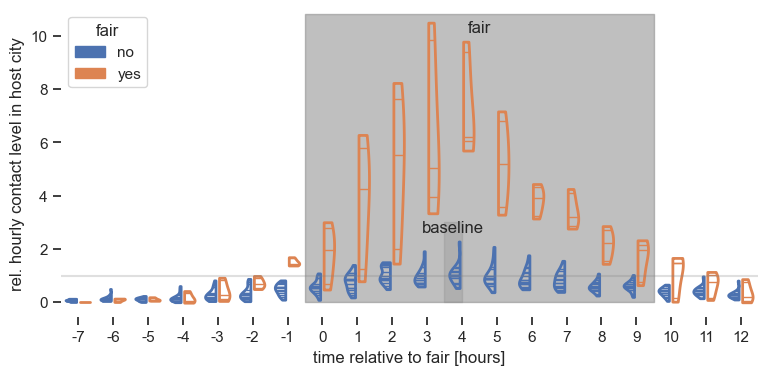

In [15]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(9, 4))
#ax.set_xscale("log")

yup = 1.1*combined_df_tobase.normed.max()
if event_here in ['DoKomi', 'Japan Day']:
    ax.fill_between([-hour_min_show-.5,-hour_min_show-.5+10], [yup,yup], color='gray', zorder=0, alpha=.5)
    ax.text(-hour_min_show-.5+5, .95*yup, 'fair', ha='center', va='center')
else:
    ax.fill_between([-hour_min_show-.5,-hour_min_show-.5+4], [yup,yup], color='gray', zorder=0, alpha=.5)
    ax.text(8.5, .95*yup if sumtoone else yup-.2, 'concert', ha='center', va='center')
if not sumtoone:
    ax.fill_between([-.5+min(hour_min)-hour_min_show,0.+min(hour_min)-hour_min_show], [yup,yup] if sumtoone else [3,3], color='gray', zorder=0, alpha=.25)
    ax.text(-.25+min(hour_min)-hour_min_show, .95*yup if sumtoone else 3-.2, 'baseline', ha='center', va='center')

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=combined_df_tobase[(combined_df_tobase.hour_rel>=hour_min_show) & (combined_df_tobase.hour_rel<=hour_max_show)],
               x="hour_rel", y="normed", hue="germany",
               split=True, bw_adjust=1, cut=.25, linewidth=2, palette=sns.color_palette(None, 2),
               fill=False, inner='stick', gap=.25, density_norm='width',
               #inner_kws=dict(box_width=7.5, whis_width=0)
              )
# Add in points to show each observation
# Show each observation with a scatterplot
#sns.stripplot(
#    data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
#    x="hour_rel", y="normed", hue="germany", palette=sns.color_palette(None, 2),#['k','k'],
#    dodge=True, alpha=.15, zorder=1, legend=False, jitter=.25,
#)

if not sumtoone:
    ax.plot([-.5, hour_max_show-hour_min_show+.5+ (-1 if event_here=='Rammstein' else 0)], [1,1], c='gray', alpha=.25)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="time relative to fair [hours]" if event_here in ['DoKomi', 'Japan Day'] else "time relative to concert [hours]")
ax.set(xlim=[-.5, hour_max_show-hour_min_show+.5])
if sumtoone:
    ax.set(ylabel="hourly contact share in host city")
else:
    ax.set(ylabel="rel. hourly contact level in host city")
ax.grid(False)
sns.despine(trim=True, bottom=True, left=True)

# Get the legend object
#legend = ax.get_legend()
handles = [mpatches.Patch(color=c) for c in sns.color_palette(None, 2)]
legend = ax.legend(handles=handles, labels=["no", "yes"], title="fair" if event_here in ['DoKomi', 'Japan Day'] else "concert", loc='upper left')

plt.savefig(f'plots/figs3/contacts_around_{event_here}_sumtoone{sumtoone}_simple.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs3/contacts_around_{event_here}_sumtoone{sumtoone}_simple.pdf', bbox_inches='tight')
plt.show()

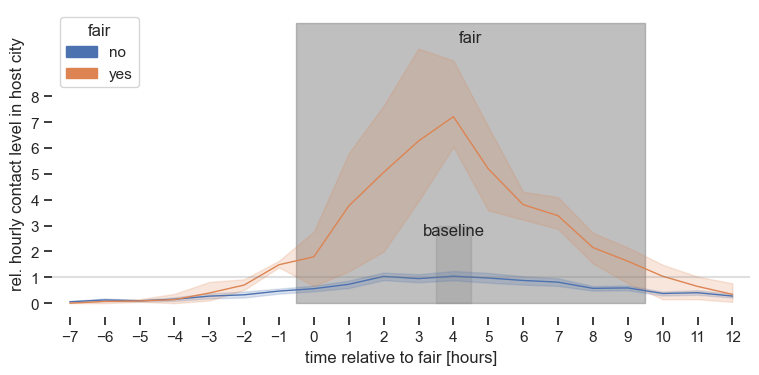

In [16]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(9, 4))
#ax.set_xscale("log")

yup = 1.1*combined_df_tobase.normed.max()
if event_here in ['DoKomi', 'Japan Day']:
    ax.fill_between([-.5,-.5+10], [yup,yup], color='gray', zorder=0, alpha=.5)
    ax.text(-.5+5, .95*yup, 'fair', ha='center', va='center')
else:
    ax.fill_between([-.5,-.5+4], [yup,yup], color='gray', zorder=0, alpha=.5)
    ax.text(8.5, .95*yup if sumtoone else yup-.2, 'concert', ha='center', va='center')
if not sumtoone:
    ax.fill_between([-.5+min(hour_min),.5+min(hour_min)], [yup,yup] if sumtoone else [3,3], color='gray', zorder=0, alpha=.25)
    ax.text(0.+min(hour_min), .95*yup if sumtoone else 3-.2, 'baseline', ha='center', va='center')

# Draw a violinplot with a narrower bandwidth than the default
sns.lineplot(data=combined_df_tobase[(combined_df_tobase.hour_rel>=hour_min_show) & (combined_df_tobase.hour_rel<=hour_max_show)],#\
               #      .groupby(['hour_rel','germany']).normed.apply(np.median).reset_index(),
               x="hour_rel", y="normed", hue="germany",
               #split=True, bw_adjust=1, cut=.25,
               linewidth=1, palette=sns.color_palette(None, 2),
               #fill=False, inner='box', gap=.25, density_norm='width',
               #inner_kws=dict(box_width=7.5, whis_width=0)
              )
#sns.violinplot(data=combined_df_tobase[(combined_df_tobase.hour_rel>=hour_min_show) & (combined_df_tobase.hour_rel<=hour_max_show)\
#                 & (combined_df_tobase.germany==False)],
#               x="hour_rel", y="normed",# hue="germany",
#               #split=True,
#               bw_adjust=1, cut=.25, linewidth=1,# palette=sns.color_palette(None, 1),#2),
#               fill=False, inner='box', #gap=.25, 
#               density_norm='width',
#               inner_kws=dict(box_width=7.5, whis_width=0)
#              )
# Add in points to show each observation
# Show each observation with a scatterplot
#sns.stripplot(
#    data=combined_df_tobase[(combined_df_tobase.hour_rel>=-7) & (combined_df_tobase.hour_rel<=5)],
#    x="hour_rel", y="normed", hue="germany", palette=sns.color_palette(None, 2),#['k','k'],
#    dodge=True, alpha=.15, zorder=1, legend=False, jitter=.25,
#)

if not sumtoone:
    ax.plot([hour_min_show-.5, hour_max_show+.5+ (-1 if event_here=='Rammstein' else 0)], [1,1], c='gray', alpha=.25)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="time relative to fair [hours]" if event_here in ['DoKomi', 'Japan Day'] else "time relative to concert [hours]")
ax.set(xlim=[hour_min_show-.5, hour_max_show+.5])
ax.set(xticks=range(hour_min_show, hour_max_show+1), yticks=range(8+1))
if sumtoone:
    ax.set(ylabel="hourly contact share in host city")
else:
    ax.set(ylabel="rel. hourly contact level in host city")
ax.grid(False)
sns.despine(trim=True, bottom=True, left=True)

# Get the legend object
#legend = ax.get_legend()
handles = [mpatches.Patch(color=c) for c in sns.color_palette(None, 2)]
legend = ax.legend(handles=handles, labels=["no", "yes"], title="fair" if event_here in ['DoKomi', 'Japan Day'] else "concert", loc='upper left')

plt.savefig(f'plots/figs3/contacts_around_{event_here}_sumtoone{sumtoone}_line.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/figs3/contacts_around_{event_here}_sumtoone{sumtoone}_line.pdf', bbox_inches='tight')
plt.show()

In [18]:
for_test = combined_df_tobase[(combined_df_tobase.hour_rel>=hour_min_show) & (combined_df_tobase.hour_rel<=hour_max_show)][['hour_rel','city','germany','normed']]
for_test

,hour_rel,city,germany,normed
3,-7,Düsseldorf,True,0.000000
4,-6,Düsseldorf,True,0.000000
5,-5,Düsseldorf,True,0.153846
6,-4,Düsseldorf,True,0.358974
7,-3,Düsseldorf,True,0.820513
...,...,...,...,...
450,8,Düsseldorf,False,0.256410
451,9,Düsseldorf,False,0.461538
452,10,Düsseldorf,False,0.358974
453,11,Düsseldorf,False,0.461538


In [19]:
for_df = []
h_significant = []
for h in sorted(list(set(for_test.hour_rel))):
    data1 = for_test[(for_test.germany==False) & (for_test.hour_rel==h)].normed.tolist()
    data2 = for_test[(for_test.germany==True) & (for_test.hour_rel==h)].normed.tolist()

    statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
    #statistic, p_value = ks_2samp(data1, data2)
    #statistic, p_value = ttest_ind(data1, data2, equal_var=False)# equal_var=False corresponds to Welch's t-test
    #print(f"Mann–Whitney U statistic: {statistic}, p-value: {p_value:.4f}")
    print(h, p_value, len(data1), len(data2))
    for_df.append(p_value)
    if p_value < .05:
        h_significant.append(h)
print(h_significant)

-7 0.03745885207976885 16 3
-6 0.5158431249910882 16 3
-5 0.8629496792158025 16 3
-4 0.5300035639626188 16 3
-3 0.6932574920020497 16 3
-2 0.04342906538873302 16 3
-1 0.008401745347355261 16 3
0 0.024771524242485198 16 3
1 0.01162474390476158 16 3
2 0.00825840850614402 16 3
3 0.008372977566717057 16 3
4 0.008344259957700082 16 3
5 0.00825840850614402 16 3
6 0.00843056326483688 16 3
7 0.00851731748857489 16 3
8 0.00843056326483688 16 3
9 0.018310361909136066 16 3
10 0.3119586984617223 16 3
11 0.397774931392612 16 3
12 0.7339223864827982 16 3
[-7, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [22]:
for hour_rel in h_significant:#range(hour_min_show, hour_max_show+1):
    np.random.seed(42)

    # Sample data
    group1 = combined_df_tobase[(combined_df_tobase.hour_rel==hour_rel) & (combined_df_tobase.germany==False)].normed.tolist()
    group2 = combined_df_tobase[(combined_df_tobase.hour_rel==hour_rel) & (combined_df_tobase.germany==True)].normed.tolist()
    #pseudocnt = combined_df_tobase[(combined_df_tobase.hour_rel==hour_rel) & (combined_df_tobase.germany==True)].baseline.apply(lambda x: 1./x).tolist()
     
    # Compute observed median difference
    median_ratio = np.median(group2) / np.median(group1) -1. # (np.median(group1)+np.median(pseudocnt)) -1.
     
    # Bootstrapping
    n_iterations = 10000
    bootstrap_ratios = []
     
    for _ in range(n_iterations):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        ratio = np.median(sample2) / np.median(sample1) -1. # (np.median(sample1)+np.median(pseudocnt)) -1.
        bootstrap_ratios.append(ratio)
     
    # Compute 95% confidence interval (2.5th and 97.5th percentiles)
    ci_lower = np.percentile(bootstrap_ratios, 2.5)
    ci_upper = np.percentile(bootstrap_ratios, 97.5)
    
    print(hour_rel, f"Median ratio: {(100*median_ratio):.1f}%", f"95% CI: ({(100*ci_lower):.1f}%, {(100*ci_upper):.1f}%)")

C:\Users\steven.schulz\AppData\Local\Temp\ipykernel_9380\457408151.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ratio = np.median(sample2) / np.median(sample1) -1. # (np.median(sample1)+np.median(pseudocnt)) -1.


-7 Median ratio: -100.0% 95% CI: (nan%, nan%)
-2 Median ratio: 160.0% 95% CI: (42.9%, 414.3%)
-1 Median ratio: 194.7% 95% CI: (145.5%, 331.2%)
0 Median ratio: 261.9% 95% CI: (13.0%, 440.0%)
1 Median ratio: 418.8% 95% CI: (41.2%, 1030.0%)
2 Median ratio: 483.8% 95% CI: (50.0%, 776.5%)
3 Median ratio: 476.5% 95% CI: (285.0%, 1180.0%)
4 Median ratio: 520.5% 95% CI: (450.0%, 863.2%)
5 Median ratio: 494.1% 95% CI: (268.4%, 682.4%)
6 Median ratio: 390.3% 95% CI: (231.6%, 546.2%)
7 Median ratio: 313.3% 95% CI: (194.7%, 566.7%)
8 Median ratio: 309.5% 95% CI: (150.0%, 437.5%)
9 Median ratio: 230.4% 95% CI: (15.4%, 300.0%)
